# Python and File Imports 

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle
import copy
import random

!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm
!pip install line_profiler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
from sklearn.model_selection import train_test_split


assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Definition of our Neural Network & Dataset Class

In [0]:
# Define our Boggle Dataset class
class BoggleDataset(Dataset):
    def __init__(self, root='./drive/My Drive/BYU/Boggle Project', size=128, train=True):
        # Initialize input variables, load the full dataset
        self.__dict__.update(locals())
        dataset_folder = os.path.join(self.root, 'boggle_dataset')
        self.transformations = transforms.Compose([transforms.Resize(self.size), transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        self.full_dataset = torchvision.datasets.ImageFolder(root=dataset_folder, transform=self.transformations)

        # Split the data into train and test 
        train_X, test_X, train_y, test_y = train_test_split(range(len(self.full_dataset)), self.full_dataset.targets, train_size=0.7, test_size=0.3, random_state=9)
        if self.train: self.dataset = torch.utils.data.Subset(self.full_dataset,train_X) 
        else: self.dataset = torch.utils.data.Subset(self.full_dataset,test_X)

    def __getitem__(self,index):
        img = self.dataset[index][0]
        label = self.dataset[index][1] # Labels are 0-25, which correspond to A-Z.
        return img,label
  
    def __len__(self):
        return len(self.dataset)

In [0]:
# Define our Model Architecture:
class BoggleNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=26):
        super(BoggleNet, self).__init__()
        # Input Size: b x 1 x 128 x 128
        self.ConvBlock1 = nn.Sequential(nn.Conv2d(input_channels, 32, kernel_size=(3,3), stride=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(32),
                                        nn.Conv2d(32, 64, kernel_size=(3,3)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(64),
                                        nn.Conv2d(64, 128, kernel_size=(3,3)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(128),
                                        nn.Dropout(p=0.1))
        
        self.ConvBlock2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=(2,2), stride=2, padding=(0,0)), # Learn the best max pooling layer using an convolution layer
                                        nn.ReLU(),
                                        nn.BatchNorm2d(64),
                                        nn.Dropout(p=0.1),
                                        nn.Conv2d(64, 32, kernel_size=(2,2), stride=2, padding=(0,0)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(32),
                                        nn.Dropout(p=0.1),
                                        nn.Conv2d(32, 16, kernel_size=(2,2), stride=2, padding=(0,0)),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(16))

        self.FullyConnected1 = nn.Sequential(nn.Linear(15, 16*15),
                                             nn.ReLU(),
                                             nn.Linear(16*15,16),
                                             nn.Flatten(),
                                             nn.Linear(15*16*16, output_channels))
            
    def forward(self, x):
        x = self.ConvBlock1(x)
        x = self.ConvBlock2(x)
        x = self.FullyConnected1(x)
        return x

# Code for Boggle Board Creation, Segmentation & Processing

In [0]:
def get_board_position(index):
    all_positions = [np.array([0, 0]), np.array([0, 1]), np.array([0, 2]),
                     np.array([0, 3]), np.array([1, 0]), np.array([1, 1]),
                     np.array([1, 2]), np.array([1, 3]), np.array([2, 0]),
                     np.array([2, 1]), np.array([2, 2]), np.array([2, 3]),
                     np.array([3, 0]), np.array([3, 1]), np.array([3, 2]),
                     np.array([3, 3])]
    return all_positions[index]

def segment_boggle_board(img_array=None,file_path='boggle_board_0.png', image_size=128, folder ='./drive/My Drive/BYU/Boggle Project'):
    """
    Segments an image of a 4x4 Boggle Board
    """
    # Read in the board as a color & grayscale image
    if img_array is None:
        full_file_path = os.path.join(folder,file_path)
        imgray = cv2.resize(cv2.cvtColor(cv2.imread(full_file_path),cv2.COLOR_BGR2GRAY), (image_size,image_size)) 
    else:
        if len(img_array.shape) != 2:
            imgray = cv2.resize(cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY), (image_size,image_size))
        else: imgray = img_array.copy()
    
    # Threshold the image so that we get distinct colors, and remove noise
    ret,thresh = cv2.threshold(imgray,127,255,0)

    # Find the contours of the image to get the bounding boxes for the letters
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # Approximate length of w/h for bounding boxes:
    w_min, h_min = np.array(imgray.shape) / 6.25
    w_max, h_max = np.array(imgray.shape) / 3.75

    # For each contour found, make sure that the ratio is a square, and meets approximate dimensions (~1/4 the size of the total height/width)
    letters = []
    for c in contours[::-1]:
        x,y,w,h = cv2.boundingRect(c)
        ratio = w/h
        if 0.9 <= ratio <= 1.1 and w_min<=w<=w_max and h_min<=h<=h_max:
            top_corner = np.min(c.squeeze(1),axis=0)
            letters.append((cv2.resize(thresh[x:x+w, y:y+h],(image_size,image_size)), top_corner))

    # Find the correct orderings for each letter:
    letters = sorted(letters, key=lambda x : x[1][0]) # Sort by y-distance from origin
    sorted_letters = []
    for i in range(0,len(letters),4):
        sorted_letters.extend(sorted(letters[i:i+4], key=lambda x: x[1][1])) # sort by x-distance from origin
    
    # Add the board position for each letter:
    for i in range(len(sorted_letters)):
        sorted_letters[i] = (sorted_letters[i][0], get_board_position(i), sorted_letters[i][1])

    return sorted_letters


In [0]:
def generate_boggle_board(folder = './drive/My Drive/BYU/Boggle Project', classic=True, image_size=1024, seed=0, return_image=True):
    """
    Generates a 4x4 boggle board using either Boggle's classic or new dice configurations. 
    Performs random flips of the letters to simulate realistic dice positions
    """

    # Load the original letter images
    letter_dict_file = os.path.join(folder, 'letter_dict.pkl')
    with open(letter_dict_file, 'rb') as file:
        letter_dict = pickle.load(file)
    
    # Define the dice for the boggle game, using either the classic configuration or new dice configuration
    classic_dice = ["RIFOBX","IFEHEY","DENOWS","UTOKND",
                    "HMSRAO","LUPETS","ACITOA","YLGKUE",
                    "QBMJOA","EHISPN","VETIGN","BALIYT",
                    "EZAVND","RALESC","UWILRG","PACEMD"]
    new_dice = ["AAEEGN", "ABBJOO", "ACHOPS", "AFFKPS",
                "AOOTTW", "CIMOTU", "DEILRX", "DELRVY",
                "DISTTY", "EEGHNW", "EEINSU", "EHRTVW",
                "EIOSST", "ELRTTY", "HIMNQU", "HLNNRZ"]

    if classic: dice = classic_dice
    else: dice = new_dice

    # Apply the random seed
    if seed != 0:
        random.seed(seed)

    # Initialize the grid, and Randomly sample from the Boggle dice to produce a valid board
    grid=[]        
    for i in range(4):
        row=[]
        for j in range(4):
            die = np.random.choice(dice,size=1)[0]
            letter = np.random.choice(list(die), size=1)[0]
            classic_dice.remove(die)
            row.append(letter)
        grid.append(row)
    
    # Begin plotting the boggle board
    fig, ax = plt.subplots(4, 4, figsize=(4, 4), facecolor='black')
    for i in range(4):
        for j in range(4):
            # Apply random rotations for each letter, either 0,90,180,270 degrees
            rotations=np.array([0,90,180,270])
            angle = rotations[np.argmax(np.random.multinomial(1, np.array([0.25,0.25,0.25,0.25])))]
            ax[i][j].imshow(ndimage.rotate(letter_dict[grid[i][j].lower()],angle,reshape=False),cmap='gray')
            ax[i][j].axis('off')
    
    if return_image:
        fig.tight_layout(pad=0.6)
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return cv2.resize(image_from_plot, (image_size, image_size))
    else:
        plt.show()

In [0]:
def predict_board(img_array=None, file_path='boggle_board_0.png', image_size=256, folder='./drive/My Drive/BYU/Boggle Project'):
    """
    Uses a trained BoggleNet to predict the letters from a boggle board. Used to solve the boggle game.
    """
    # Load the model from the saved weights from training the BoggleNet
    # & put it in evaluation mode
    print("Loading BoggleNet Model")
    weights_filename = os.path.join(folder, 'boggleNet_weights.pth')
    model = BoggleNet()
    state_dict = torch.load(weights_filename)
    model.load_state_dict(state_dict)
    model.eval()
    print("Model Loaded")

    # Segment the board
    letters = segment_boggle_board(img_array=img_array, file_path=file_path, image_size=image_size, folder=folder)

    # Define the dictionary for our classifier
    class_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 
     10: 'K', 11: 'L', 12:'M', 13:'N', 14:'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 
     21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}

    transformations = transforms.Compose([transforms.ToPILImage(),
                                          transforms.Grayscale(),
                                          transforms.Resize(128), 
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5], [0.5])])

    # Initialize the board:
    boggle_board = [[0,0,0,0],[0,0,0,0],[0,0,0,0], [0,0,0,0]]

    if img_array is None:
        plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(folder, file_path)),cv2.COLOR_BGR2GRAY),cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY),cmap='gray')
    plt.axis("off")
    plt.title("\nActual Boggle Board")
    plt.show()

    # Predict on each of the letters
    for i, (letter, position,_) in enumerate(letters):
        ret,letter = cv2.threshold(letter,127,255,0)
        transformed_letter = transformations(letter)
        plt.subplot(4,4,i+1)
        plt.imshow(transformed_letter.squeeze(0).numpy(), cmap='gray')
        plt.axis('off')

        output = model(transformed_letter.unsqueeze(0))
        predicted_letter = class_dict[output.argmax(1).item()]
        boggle_board[position[0]][position[1]] = predicted_letter
        # print("Letter that was predicted: {}".format(predicted_letter))
    plt.suptitle("\nSegmented Board for Predictions")
    plt.show()
    print("PREDICTED BOGGLE BOARD:")
    print(*boggle_board,sep='\n')

    return boggle_board

# Testing the Boggle Board Prediction Pipeline

Loading BoggleNet Model
Model Loaded


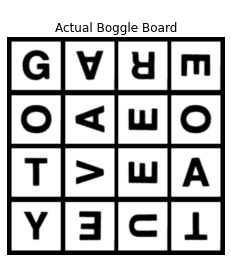

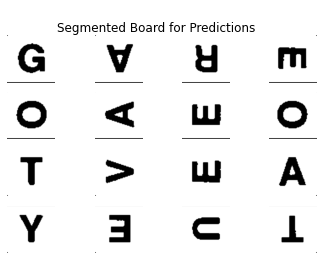

PREDICTED BOGGLE BOARD:
['G', 'A', 'R', 'E']
['O', 'A', 'E', 'O']
['T', 'V', 'E', 'A']
['Y', 'E', 'U', 'T']


In [467]:
# Randomly generate a new boggle board, and use our model to predict the letters that show up.
boggle_board_image = generate_boggle_board()
boggle_board = predict_board(img_array = boggle_board_image)

# Solving for all Possible Words in the Boggle Puzzle

In [0]:
class BoggleBoard():
    def __init__(self, boggle_board, words_file='words.txt', folder = './drive/My Drive/BYU/Boggle Project'):
        self.__dict__.update(locals())
        self.valid_words = self.load_words(os.path.join(folder, words_file))
        self.total_score = 0
        self.words_found = []
        self.find_all_words()

    def load_words(self, file = "words.txt"):
        '''
        Loads in words from the dictionary.
        '''
        valid_words=[]
        with open(file, 'r') as in_file:
            #Get rid of the first two lines in the document
            valid_words = in_file.read().split('\n')[2:]
        return valid_words

    def __repr__(self):
        return '\n'.join(['[' + ', '.join(row) + ']' for row in self.boggle_board])
    
    def score_word(self, word):
        """
        Scores words according to their length, using Boggle's rules.
        """
        if len(word) < 3: return 0
        elif len(word) in [3,4]: return 1
        elif len(word) == 5: return 2
        elif len(word) == 6: return 3
        elif len(word) == 7: return 5
        elif len(word) >= 8: return 11
    
    def check(self, word,i):
        '''
        Returns the array index of the first word in self.valid_words
        that is not before word in alphabetical order.
        '''
        # Move through the words until we are alphabetically in order
        while word.upper() > self.valid_words[i].upper():
            i += 1
        # Finds the first word that matches the current word's string
        if word.upper() == self.valid_words[i][:len(word)].upper(): return i
        else: return -1

    def seek(self,grid,m,n,used,word,location,words_found):
        '''
        Recursively looks for words in the grid.
        Does not return a value.
        '''
        # Try adding the next letter & validate if it is part of a word
        new_word = word.upper() + grid[m][n].upper()
        if grid[m][n].upper() == "Q":
            new_word += "U"
        
        # Check if the new word we have is a valid word & update its location from our list
        location = self.check(new_word, location)
        if location == -1: return
        if location != -1:
            if new_word.upper() == self.valid_words[location].upper() and new_word.lower() not in words_found and len(new_word) > 2:
                word_score = self.score_word(new_word)
                self.total_score += word_score
                words_found.append(new_word.lower())
            
            # Recursively go through the adjacent letters and find more valid words
            for new_m in [m,m-1,m+1]:
                for new_n in [n,n-1, n+1]:
                    # Make sure indices are valid & not repeats of the current square
                    if 0 <= new_m <= 3 and 0 <= new_n <= 3 and [new_m,new_n] not in used and [new_m,new_n] != [m,n]:
                        self.seek(grid, new_m, new_n, used + [[m,n]], new_word,location, words_found)

    def find_all_words(self):
        '''
        Finds all words in the grid, stores them in the class.
        If verbose=True, also prints the list of top 20 found words and their corresponding score
        '''
        # Start at the top left corner, and recursively find all words starting on each square
        for i in range(4):
            for j in range(4):
                self.seek(self.boggle_board,i,j,[],"",0,self.words_found)
        self.scored_words = sorted(list(map(lambda x: (x,self.score_word(x)), self.words_found)), key=lambda x: -x[1])
        print("All words found and scored.")
    
    def get_words(self, num_words=None,easier=True):
        """
        Returns the top num_words words based on their scores (length).
        Defaults to print all words
        """
        if num_words is None:
            num_words = len(self.words_found)
        print(f"The top {num_words} words and corresponding scores are: ")
        if easier == True:
            print('\n'.join([': '.join([str(x) for x in pair]) for pair in self.scored_words[::-1][:num_words]]))
            print("The score for these words is: {}".format(sum([x[1] for x in self.scored_words[::-1][:num_words]])))
            print("The highest possible score for this board is: {}".format(self.total_score))
        else:
            print('\n'.join([': '.join([str(x) for x in pair]) for pair in self.scored_words[:num_words]]))
            print("The score for these words is: {}".format(sum([x[1] for x in self.scored_words[:num_words]])))
            print("The highest possible score for this board is: {}".format(self.total_score))

# Testing Full Boggle Pipeline

In [10]:
boggle_board = [['G', 'A', 'R', 'E'],
['O', 'A', 'E', 'O'],
['T', 'V', 'E', 'A'],
['Y', 'E', 'U', 'T']]
solved_board = BoggleBoard(boggle_board)
solved_board.get_words(10,easier=False)

All words found and scored.
The top 10 words and corresponding scores are: 
overate: 5
goatee: 3
aerate: 3
revote: 3
gavot: 2
agave: 2
agate: 2
areae: 2
reeve: 2
reave: 2
The score for these words is: 26
The highest possible score for this board is: 107


Loading BoggleNet Model
Model Loaded


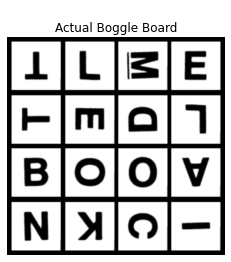

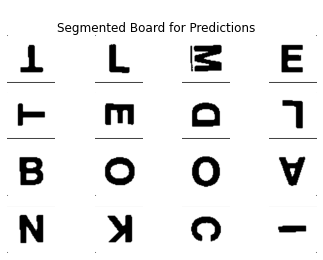

PREDICTED BOGGLE BOARD:
['T', 'L', 'M', 'E']
['L', 'E', 'D', 'L']
['B', 'O', 'O', 'A']
['N', 'K', 'C', 'I']
All words found and scored.
The top 10 words and corresponding scores are: 
melodeon: 11
knolled: 5
locoed: 3
locale: 3
boodle: 3
bolted: 3
bolled: 3
noodle: 3
cooled: 3
coaled: 3
The score for these words is: 40
The highest possible score for this board is: 207


In [518]:
boggle_board_image = generate_boggle_board()
boggle_board = predict_board(img_array = boggle_board_image)
solved_board = BoggleBoard(boggle_board)
solved_board.get_words(10,easier=False)

Loading BoggleNet Model
Model Loaded


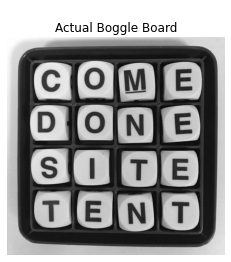

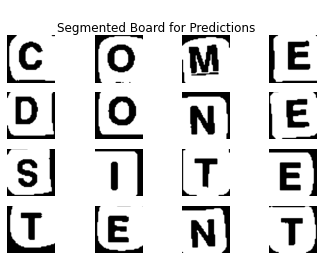

PREDICTED BOGGLE BOARD:
['G', 'O', 'M', 'E']
['U', 'O', 'N', 'E']
['S', 'L', 'T', 'H']
['O', 'E', 'N', 'T']
All words found and scored.
The top 30 words and corresponding scores are: 
els: 1
oes: 1
het: 1
heme: 1
hem: 1
hent: 1
hen: 1
tels: 1
tel: 1
tent: 1
teen: 1
teem: 1
tee: 1
ten: 1
tole: 1
tolu: 1
tome: 1
tom: 1
tog: 1
toon: 1
toom: 1
too: 1
tone: 1
ton: 1
them: 1
thee: 1
then: 1
the: 1
let: 1
les: 1
The score for these words is: 30
The highest possible score for this board is: 250


In [513]:
# boggle_board_image = generate_boggle_board()
boggle_board = predict_board(file_path='boggle_board_1.jpg')
solved_board = BoggleBoard(boggle_board)
solved_board.get_words(30, easier=True)